In [143]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [144]:
import matplotlib.pyplot as plt
import math
import torch
from torch.optim.lr_scheduler import StepLR
import numpy as np

In [145]:
# 迭代次数
EPOCH = 1500
# 学习率
MLP_LR = 0.01
left, right = -2,2
PI = math.pi
NUM=50

In [146]:
# 模拟数据
x = torch.tensor([(num * PI) for num in np.arange(left, right, (right - left) / NUM)], dtype=torch.float)
print(x)
y = torch.sin(x)
print(y)

tensor([-6.2832e+00, -6.0319e+00, -5.7805e+00, -5.5292e+00, -5.2779e+00,
        -5.0265e+00, -4.7752e+00, -4.5239e+00, -4.2726e+00, -4.0212e+00,
        -3.7699e+00, -3.5186e+00, -3.2673e+00, -3.0159e+00, -2.7646e+00,
        -2.5133e+00, -2.2619e+00, -2.0106e+00, -1.7593e+00, -1.5080e+00,
        -1.2566e+00, -1.0053e+00, -7.5398e-01, -5.0265e-01, -2.5133e-01,
         5.5806e-15,  2.5133e-01,  5.0265e-01,  7.5398e-01,  1.0053e+00,
         1.2566e+00,  1.5080e+00,  1.7593e+00,  2.0106e+00,  2.2619e+00,
         2.5133e+00,  2.7646e+00,  3.0159e+00,  3.2673e+00,  3.5186e+00,
         3.7699e+00,  4.0212e+00,  4.2726e+00,  4.5239e+00,  4.7752e+00,
         5.0265e+00,  5.2779e+00,  5.5292e+00,  5.7805e+00,  6.0319e+00])
tensor([-1.7485e-07,  2.4869e-01,  4.8175e-01,  6.8455e-01,  8.4433e-01,
         9.5106e-01,  9.9803e-01,  9.8229e-01,  9.0483e-01,  7.7051e-01,
         5.8779e-01,  3.6812e-01,  1.2533e-01, -1.2533e-01, -3.6812e-01,
        -5.8779e-01, -7.7051e-01, -9.0483e-01, -9.

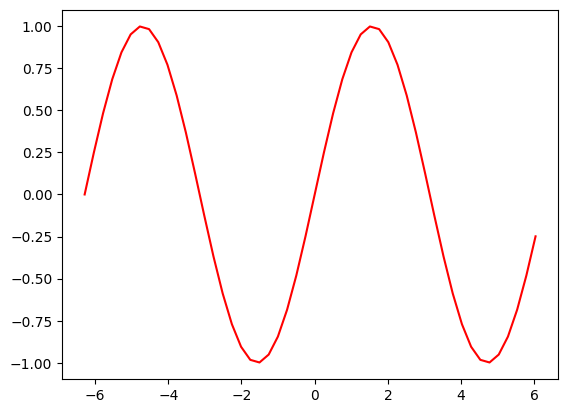

In [147]:
plt.plot(x,y,color='red')
plt.show()

In [148]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 定义第一层，输入1个单元，输出20个单元
        self.layer1 = torch.nn.Linear(1,20)
        self.layer2 = torch.nn.Linear(20,20)
        self.layer3 = torch.nn.Linear(20,1)

    # 向前传播
    def forward(self,x):
        # 三层

        x = self.layer1(x)
        # 激活函数
        x = torch.nn.functional.relu(x)
        
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)

        x = self.layer3(x)        
        return x
    

In [149]:
# 实例化神经网络
mlp = MLP()

#  input_x ,label 是输入和标签

# 将输入变为列向量
input_x = x.reshape(-1,1)
labels = y.reshape(-1,1)

In [150]:
# 训练mlp

# 创建一个Adam优化器，接受mlp.parameter()获取MLT模型中需要优化的参数，设置了学习率MLP_LR
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=MLP_LR)
# 学习率衰减调度
scheduler = StepLR(mlp_optimizer, step_size=100, gamma=0.9)

# 存储每一代的损失值
mlp_loss=[]
mlp_lr = []

for epoch in range(EPOCH):
    # 获取预测值
    
    # 调用类__call__()方法，通过类名调用函数
    # 此处调用forward()方法
    preds = mlp(input_x)

    # 计算代价函数，将其与标签labels比较，计算损失值 preb是模型计算值，labels是输入值
    loss = torch.nn.functional.mse_loss(preds,labels)

    # 计算梯度
    # 清空梯度
    mlp_optimizer.zero_grad()
    loss.backward()
    
    #  执行一步优化器的更新操作，根据梯度更新模型的参数。
    # 调用优化器对象step()方法，根据当前梯度值，学习率更新模型参数
    mlp_optimizer.step()
    
    # 存储损失值
    mlp_loss.append(loss.item())
    mlp_lr.append(mlp_optimizer.state_dict()['param_groups'][0]['lr'])
    # 在每个 epoch 结束后更新学习率
    scheduler.step()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


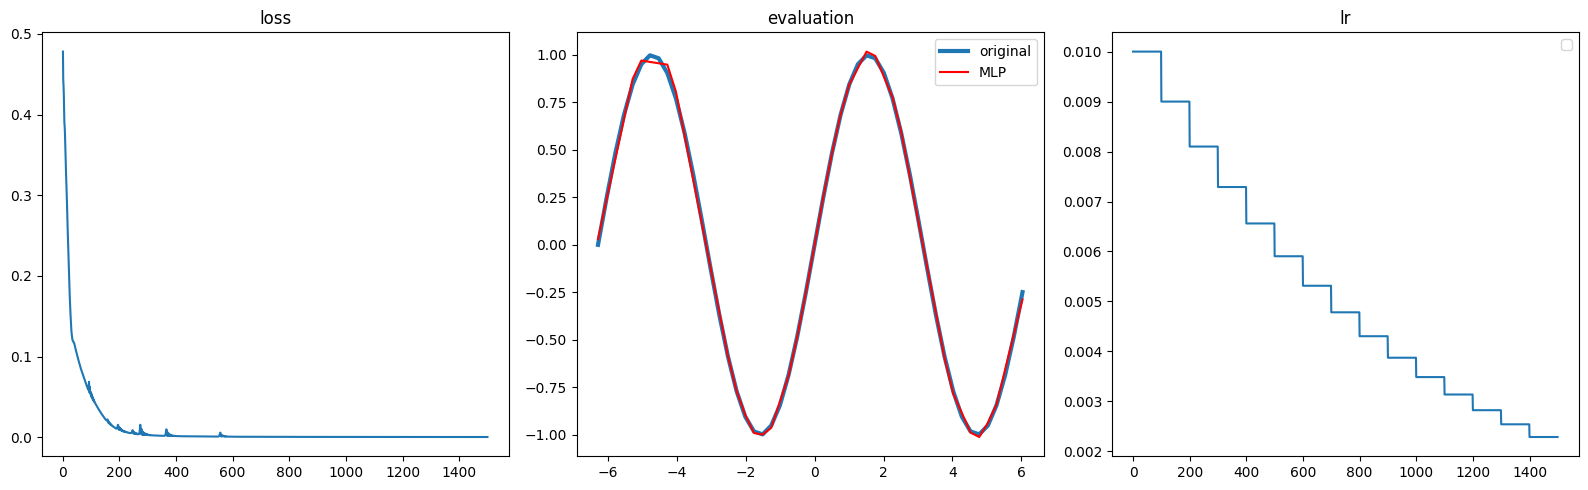

In [151]:
# 可视化训练过程，测试结果
def PlotMLP(mlp, input_x, x):
    # input_x 输入值

    # 首先，通过调用 mlp.eval() 将模型转换为评估模式，以禁用丢弃(dropout)和批标准化(batch normalization)等防止过拟合的技巧。这可以使模型的输出更加稳定，以便进行可视化。
    mlp_eval = mlp.eval()
    # 对输入数据 input_x 进行前向传播，得到预测结果 mlp_y
    mlp_y = mlp_eval(input_x)
    #      tensor 在cpu计算 创建新数组，梯度与原数组无关
    mlp_y_np=mlp_y.cpu().detach().numpy()

    # 创建图像画布指定宽高
    plt.figure(figsize=(16,5))

    plt.subplot(1,3,1)
    plt.plot([i + 1 for i in range(EPOCH)], mlp_loss, label='MLP')
    plt.title('loss')
    plt.subplot(1,3,2)
    # 图例
    plt.legend()
    plt.plot(x, torch.sin(x), label="original", linewidth=3)
    plt.plot(x, [y[0] for y in mlp_y_np], label='MLP',color='red')
    plt.title('evaluation')
    plt.legend()

    plt.subplot(1,3,3)
    plt.legend()
    plt.title('lr')
    plt.plot([i for i in range(len(mlp_lr))],mlp_lr)

    plt.tight_layout()
    plt.show()
PlotMLP(mlp,input_x,x)

In [152]:
for name,para in mlp.named_parameters():
    print(name,para.numel(),para.data.tolist())

layer1.weight 20 [[0.022053994238376617], [0.5847851037979126], [0.879809558391571], [-0.6088683605194092], [0.04992322623729706], [0.06584596633911133], [-0.9972587823867798], [-0.1761995553970337], [-0.31673726439476013], [-0.7290424108505249], [-1.0855562686920166], [-0.9266295433044434], [0.4080601930618286], [0.9587446451187134], [0.29857850074768066], [0.3696466386318207], [-0.3707079589366913], [0.5487682223320007], [0.6911208629608154], [1.2164579629898071]]
layer1.bias 20 [-0.3044397532939911, -0.19599954783916473, -0.3860374689102173, 0.5918376445770264, 0.5856274962425232, -0.5890300273895264, 0.5721835494041443, 0.9203701019287109, 1.244004487991333, -0.2615695893764496, 0.2325078397989273, 0.09786904603242874, 0.01715988852083683, 0.5060107707977295, 1.5400705337524414, 1.5425899028778076, 1.7283849716186523, 0.2951430678367615, -0.44798460602760315, 0.1589847207069397]
layer2.weight 400 [[-0.17976848781108856, -0.19036930799484253, -0.021540164947509766, -0.12527041137218